### Following [Baboota's](https://doi.org/10.1016/j.ijforecast.2018.01.003) fantastic paper, this is an attempt to partially emulate the results and methodology using a Random Forest. 

The core implementation focuses on attaching FIFA club rankings to the match-sheet dataset as features, and subsequently calculating strength differentials and rolling features (such as "Form" and "Streak") that produce better results than static features alone. This is a work in progress, that will continue with a similar implementation using a Boosting algorithm. Features to be added at a later date include Total and Club Value (from Transfermarkt) and ELO rankings.

In [25]:
!pip install scipy==1.11.4

In [26]:
import scipy
print(scipy.__version__)

1.11.4


In [27]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from scipy import interp
from pprint import pprint
from itertools import cycle
import matplotlib.pyplot as plt
from collections import OrderedDict
import joblib
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [28]:
%matplotlib inline

In [29]:
from bs4 import BeautifulSoup as Soup

# Load the HTML file
with open("/kaggle/input/fifa17htmlonly/Team Stats Database - FIFA 17 - FIFA Index.html", "r", encoding="utf-8") as file:
    p_soup = file.read()

# Parse the HTML
data = Soup(p_soup, "html.parser")

# Locate the table body
table = data.find("tbody")  # Find the <tbody> containing the rows

if table:
    # Find all rows in the table
    rows = table.find_all("tr")
    team_data = []  # List to store extracted team information

    for row in rows:
        row_html = str(row)  # Convert the row to a string for pattern matching
        # Check if the row matches the expected pattern
        if '<tr><td><a class="link-team"' in row_html and '</i></span></td></tr>' in row_html:
            # Extract <td> elements
            td = row.find_all("td")
            if len(td) >= 7:  # Ensure the row has at least 7 <td> elements
                try:
                    # Extract data
                    team_name = td[1].find("a").text.strip()
                    attack = td[3].find("span").text.strip()
                    midfield = td[4].find("span").text.strip()
                    defense = td[5].find("span").text.strip()
                    overall = td[6].find("span").text.strip()

                    # Append to list
                    team_data.append({
                        "Team": team_name,
                        "Attack": int(attack),
                        "Midfield": int(midfield),
                        "Defense": int(defense),
                        "Overall": int(overall)
                    })
                except Exception as e:
                    print(f"Error processing row: {e}")

    # Print results
    for team in team_data:
        print(team)
else:
    print("Table body not found in the HTML.")


{'Team': 'Chelsea', 'Attack': 86, 'Midfield': 84, 'Defense': 81, 'Overall': 83}
{'Team': 'Manchester United', 'Attack': 84, 'Midfield': 84, 'Defense': 82, 'Overall': 83}
{'Team': 'Manchester City', 'Attack': 83, 'Midfield': 85, 'Defense': 81, 'Overall': 83}
{'Team': 'Arsenal', 'Attack': 81, 'Midfield': 83, 'Defense': 82, 'Overall': 83}
{'Team': 'Tottenham Hotspur', 'Attack': 85, 'Midfield': 81, 'Defense': 81, 'Overall': 81}
{'Team': 'Liverpool', 'Attack': 82, 'Midfield': 81, 'Defense': 81, 'Overall': 81}
{'Team': 'Everton', 'Attack': 85, 'Midfield': 78, 'Defense': 79, 'Overall': 80}
{'Team': 'Leicester City', 'Attack': 79, 'Midfield': 78, 'Defense': 76, 'Overall': 78}
{'Team': 'West Ham United', 'Attack': 79, 'Midfield': 77, 'Defense': 77, 'Overall': 78}
{'Team': 'Southampton', 'Attack': 78, 'Midfield': 76, 'Defense': 77, 'Overall': 78}
{'Team': 'Stoke City', 'Attack': 77, 'Midfield': 78, 'Defense': 77, 'Overall': 78}
{'Team': 'Crystal Palace', 'Attack': 80, 'Midfield': 77, 'Defense': 

In [30]:
for team in team_data:
        print(team["Team"])

Chelsea
Manchester United
Manchester City
Arsenal
Tottenham Hotspur
Liverpool
Everton
Leicester City
West Ham United
Southampton
Stoke City
Crystal Palace
Watford
Swansea City
Sunderland
West Bromwich Albion
Hull City
Middlesbrough
Bournemouth
Burnley


In [31]:
pd.DataFrame(team_data).to_csv('fifa17_epl_team_ratings.csv', index=False)
#print("Data saved to fifa17_epl_team_ratings.csv.")
fifa_ratings = pd.read_csv("fifa17_epl_team_ratings.csv")
#fifa_ratings["Team"]

In [32]:
match_data = pd.read_csv("/kaggle/input/epl1718/E0.csv")
match_data["HomeTeam"].unique()

array(['Arsenal', 'Brighton', 'Chelsea', 'Crystal Palace', 'Everton',
       'Southampton', 'Watford', 'West Brom', 'Man United', 'Newcastle',
       'Bournemouth', 'Burnley', 'Leicester', 'Liverpool', 'Stoke',
       'Swansea', 'Huddersfield', 'Tottenham', 'Man City', 'West Ham'],
      dtype=object)

In [33]:
# hull, middle, sunder -> newc, brighton, hudd
# Define name mapping
name_mapping = {
    "Manchester United": "Man United",
    "Manchester City": "Man City",
    "Tottenham Hotspur": "Tottenham",
    "Leicester City": "Leicester",
    "West Ham United": "West Ham",
    "Southampton": "Southampton",
    "Stoke City": "Stoke",
    "Crystal Palace": "Crystal Palace",
    "Watford": "Watford",
    "Swansea City": "Swansea",
    "Sunderland": "Sunderland",
    "West Bromwich Albion": "West Brom",
    "Hull City": "Hull",
    "Middlesbrough": "Middlesbrough",
    "Bournemouth": "Bournemouth",
    "Burnley": "Burnley",
    "Chelsea": "Chelsea",
    "Arsenal": "Arsenal",
    "Liverpool": "Liverpool",
    "Everton": "Everton",
}

fifa_ratings["Team"] = fifa_ratings["Team"].replace(name_mapping)

In [34]:
fifa_ratings["Team"]

0            Chelsea
1         Man United
2           Man City
3            Arsenal
4          Tottenham
5          Liverpool
6            Everton
7          Leicester
8           West Ham
9        Southampton
10             Stoke
11    Crystal Palace
12           Watford
13           Swansea
14        Sunderland
15         West Brom
16              Hull
17     Middlesbrough
18       Bournemouth
19           Burnley
Name: Team, dtype: object

In [35]:
match_data = match_data.merge(
        fifa_ratings,
        how="left",
        left_on="HomeTeam",
        right_on="Team"
    ).rename(columns={
        "Attack": "HomeAttack",
        "Midfield": "HomeMidfield",
        "Defense": "HomeDefense",
        "Overall": "HomeOverall"
    }).drop(columns=["Team"])



In [36]:
 match_data = match_data.merge(
        fifa_ratings,
        how="left",
        left_on="AwayTeam",
        right_on="Team"
    ).rename(columns={
        "Attack": "AwayAttack",
        "Midfield": "AwayMidfield",
        "Defense": "AwayDefense",
        "Overall": "AwayOverall"
    }).drop(columns=["Team"])

In [37]:
default_rating=70
# Handle missing ratings by imputing default values
match_data.fillna(default_rating, inplace=True)

    # Ensure ratings are integers
rating_columns = [
        "HomeAttack", "HomeMidfield", "HomeDefense", "HomeOverall",
        "AwayAttack", "AwayMidfield", "AwayDefense", "AwayOverall"
    ]
match_data[rating_columns] = match_data[rating_columns].astype(int)

In [38]:
def engineer_features(epl_data):
    # Calculate team strength differentials
    epl_data["AttackDifferential"] = epl_data["HomeAttack"] - epl_data["AwayAttack"]
    epl_data["MidfieldDifferential"] = epl_data["HomeMidfield"] - epl_data["AwayMidfield"]
    epl_data["DefenseDifferential"] = epl_data["HomeDefense"] - epl_data["AwayDefense"]
    epl_data["OverallDifferential"] = epl_data["HomeOverall"] - epl_data["AwayOverall"]

    # Initialize goal differential columns
    epl_data["HomeGoalDiff"] = epl_data["FTHG"] - epl_data["FTAG"]  # Match-specific goal diff
    epl_data["AwayGoalDiff"] = epl_data["FTAG"] - epl_data["FTHG"]

    # Cumulative goal differential
    team_goal_diff = {}
    def calculate_goal_diff(row):
        home_team = row["HomeTeam"]
        away_team = row["AwayTeam"]
        home_diff = row["HomeGoalDiff"]
        away_diff = row["AwayGoalDiff"]

        # Update cumulative goal differentials
        team_goal_diff[home_team] = team_goal_diff.get(home_team, 0) + home_diff
        team_goal_diff[away_team] = team_goal_diff.get(away_team, 0) + away_diff

        return pd.Series({
            "CumulativeHomeGoalDiff": team_goal_diff[home_team],
            "CumulativeAwayGoalDiff": team_goal_diff[away_team],
        })

    epl_data[["CumulativeHomeGoalDiff", "CumulativeAwayGoalDiff"]] = epl_data.apply(calculate_goal_diff, axis=1)

    # Rolling form over last 5 matches
    team_points = {}
    def calculate_form(row):
        home_team = row["HomeTeam"]
        away_team = row["AwayTeam"]
        result = row["FTR"]  # Full-time result: H (home win), A (away win), D (draw)

        # Points assignment
        if result == "H":
            team_points[home_team] = team_points.get(home_team, []) + [3]
            team_points[away_team] = team_points.get(away_team, []) + [0]
        elif result == "A":
            team_points[home_team] = team_points.get(home_team, []) + [0]
            team_points[away_team] = team_points.get(away_team, []) + [3]
        else:
            team_points[home_team] = team_points.get(home_team, []) + [1]
            team_points[away_team] = team_points.get(away_team, []) + [1]

        # Rolling average form
        home_form = sum(team_points[home_team][-5:]) / min(5, len(team_points[home_team]))
        away_form = sum(team_points[away_team][-5:]) / min(5, len(team_points[away_team]))

        return pd.Series({
            "HomeForm": home_form,
            "AwayForm": away_form,
        })

    epl_data[["HomeForm", "AwayForm"]] = epl_data.apply(calculate_form, axis=1)

    # Add home advantage (binary feature)
    epl_data["HomeAdvantage"] = 1

    return epl_data


In [39]:
dataf = engineer_features(match_data)

In [40]:
def calculate_weighted_shots(data):
    # Create weighted shots columns
    data["AStWeighted"] = (data["ASt"] * data.index) / len(data)
    data["HStWeighted"] = (data["HSt"] * data.index) / len(data)
    return data

def engineer_missing_features(epl_data):
    # Corner Kicks Per Game
    epl_data["ACKPP"] = epl_data["AC"] / epl_data.groupby("AwayTeam")["AwayTeam"].transform("count")
    epl_data["HCKPP"] = epl_data["HC"] / epl_data.groupby("HomeTeam")["HomeTeam"].transform("count")

    # Goalkeeper Saves Per Game
    epl_data["AGKPP"] = (epl_data["HS"] - epl_data["FTHG"]) / epl_data.groupby("AwayTeam")["AwayTeam"].transform("count")
    epl_data["HGKPP"] = (epl_data["AS"] - epl_data["FTAG"]) / epl_data.groupby("HomeTeam")["HomeTeam"].transform("count")

    # Shots on Target Per Game
    epl_data["ASTKPP"] = epl_data["AST"] / epl_data.groupby("AwayTeam")["AwayTeam"].transform("count")
    epl_data["HSTKPP"] = epl_data["HST"] / epl_data.groupby("HomeTeam")["HomeTeam"].transform("count")

    # Total Shots
    epl_data["ASt"] = epl_data["AS"]
    epl_data["HSt"] = epl_data["HS"]

    # Apply weighted shots calculation explicitly without grouping behavior issues
    epl_data = epl_data.copy()  # Ensure original structure
    epl_data = calculate_weighted_shots(epl_data)

    # Streak and Weighted Streak
    streaks = {}
    weighted_streaks = {}

    def calculate_streak(row):
        home_team = row["HomeTeam"]
        away_team = row["AwayTeam"]
        result = row["FTR"]

        # Initialize if not already done
        if home_team not in streaks:
            streaks[home_team] = 0
        if away_team not in streaks:
            streaks[away_team] = 0

        # Update streaks
        if result == "H":
            streaks[home_team] += 1
            streaks[away_team] = 0
        elif result == "A":
            streaks[away_team] += 1
            streaks[home_team] = 0
        else:  # Draw
            streaks[home_team] = 0
            streaks[away_team] = 0

        # Weighted Streaks
        weighted_streaks[home_team] = streaks[home_team] * 1.5
        weighted_streaks[away_team] = streaks[away_team] * 1.5

        return pd.Series({
            "HomeStreak": streaks[home_team],
            "AwayStreak": streaks[away_team],
            "HomeWeightedStreak": weighted_streaks[home_team],
            "AwayWeightedStreak": weighted_streaks[away_team]
        })

    streak_data = epl_data.apply(calculate_streak, axis=1)
    epl_data = pd.concat([epl_data, streak_data], axis=1)

    return epl_data


In [41]:
# Apply the function to the dataset
dataff = engineer_missing_features(dataf)
dataff.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,ASTKPP,HSTKPP,ASt,HSt,AStWeighted,HStWeighted,HomeStreak,AwayStreak,HomeWeightedStreak,AwayWeightedStreak
0,E0,11/08/2017,Arsenal,Leicester,4,3,H,2,2,D,...,0.157895,0.526316,6,27,0.000000,0.000000,1.0,0.0,1.5,0.0
1,E0,12/08/2017,Brighton,Man City,0,2,A,0,0,D,...,0.210526,0.105263,14,6,0.036842,0.015789,0.0,1.0,0.0,1.5
2,E0,12/08/2017,Chelsea,Burnley,2,3,A,0,3,A,...,0.263158,0.315789,10,19,0.052632,0.100000,0.0,1.0,0.0,1.5
3,E0,12/08/2017,Crystal Palace,Huddersfield,0,3,A,0,2,A,...,0.315789,0.210526,8,14,0.063158,0.110526,0.0,1.0,0.0,1.5
4,E0,12/08/2017,Everton,Stoke,1,0,H,1,0,H,...,0.052632,0.210526,9,9,0.094737,0.094737,1.0,0.0,1.5,0.0


In [42]:
#from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Convert 'Date' column to datetime
dataff["Date"] = pd.to_datetime(dataff["Date"], format='%d/%m/%Y')

# Sort the data by date
dataff.sort_values(by="Date", inplace=True)
# Define split index (80% train, 20% test)
split_index = int(len(dataff) * 0.8)

# Define the target variable: Match outcome
# Encode FTR: 'H' (Home win) = 1, 'D' (Draw) = 0, 'A' (Away win) = -1
dataff["FTR_encoded"] = dataff["FTR"].map({"H": 1, "D": 0, "A": -1})

# Define feature columns
features = [
    "AttackDifferential", "MidfieldDifferential", "DefenseDifferential", 
    "OverallDifferential", "CumulativeHomeGoalDiff", "CumulativeAwayGoalDiff",
    "HomeForm", "AwayForm", "HomeAdvantage", "ACKPP", "HCKPP", "AGKPP", "HGKPP",
    "ASTKPP", "HSTKPP", "AStWeighted", "HStWeighted", "HomeStreak", "AwayStreak",
    "HomeWeightedStreak", "AwayWeightedStreak"
]

# Split the data chronologically
train_data = dataff.iloc[:split_index]
test_data = dataff.iloc[split_index:]

# Separate features and target for both sets
X_train = train_data[features]
y_train = train_data["FTR_encoded"]

X_test = test_data[features]
y_test = test_data["FTR_encoded"]


In [43]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        25
           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        32

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76



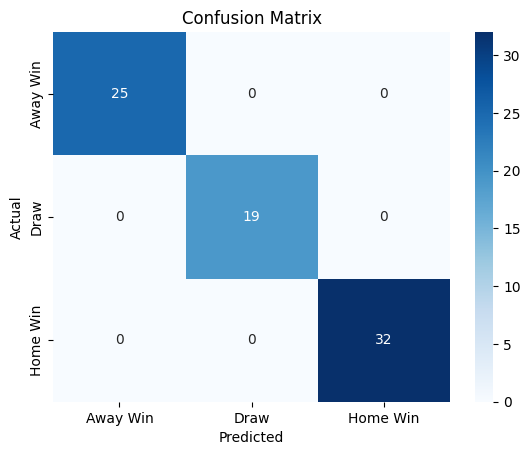

In [44]:
# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Away Win", "Draw", "Home Win"], yticklabels=["Away Win", "Draw", "Home Win"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


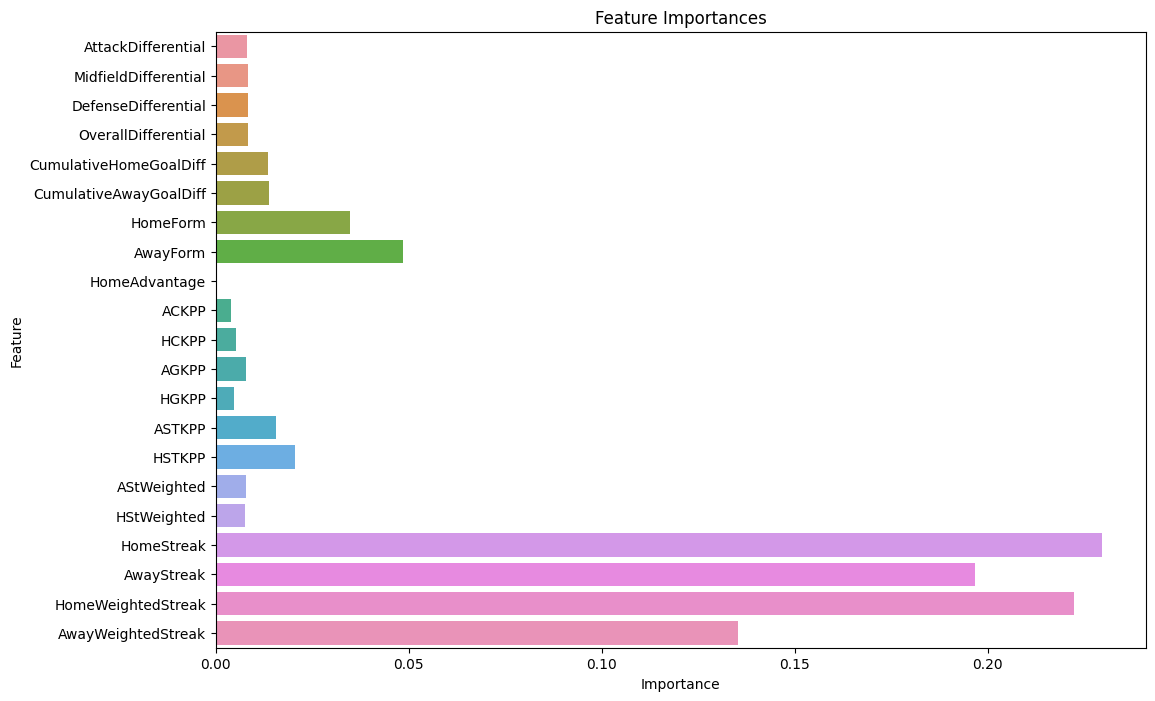

In [45]:
# Plot feature importances
importances = rf_model.feature_importances_
plt.figure(figsize=(12, 8))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [46]:
# Create a DataFrame with predictions and actual results
test_results = X_test.copy()
test_results["Actual"] = y_test.values
test_results["Predicted"] = y_pred

# Decode the encoded results for readability
result_mapping = {1: "Home Win", 0: "Draw", -1: "Away Win"}
test_results["Actual"] = test_results["Actual"].map(result_mapping)
test_results["Predicted"] = test_results["Predicted"].map(result_mapping)

# Display the first few rows of the test set with predictions
print(test_results[["Actual", "Predicted"]].head(10))


       Actual Predicted
309      Draw      Draw
311  Home Win  Home Win
310  Away Win  Away Win
308  Home Win  Home Win
307  Home Win  Home Win
306  Away Win  Away Win
305  Away Win  Away Win
304  Away Win  Away Win
312  Home Win  Home Win
313  Away Win  Away Win


In [47]:
# Select relevant columns for visualization
future_games = test_results[[
    "Actual", "Predicted", "AttackDifferential", "MidfieldDifferential",
    "DefenseDifferential", "OverallDifferential", "HomeForm", "AwayForm"
]]

# Display the first 10 rows in a tabular format
print(future_games.head(10))


       Actual Predicted  AttackDifferential  MidfieldDifferential  \
309      Draw      Draw                   4                     3   
311  Home Win  Home Win                   1                     1   
310  Away Win  Away Win                   7                     2   
308  Home Win  Home Win                   0                     0   
307  Home Win  Home Win                   6                     8   
306  Away Win  Away Win                   2                    -7   
305  Away Win  Away Win                  -2                    -4   
304  Away Win  Away Win                  -9                    -8   
312  Home Win  Home Win                   4                     5   
313  Away Win  Away Win                   1                     3   

     DefenseDifferential  OverallDifferential  HomeForm  AwayForm  
309                    2                    3       1.4       1.2  
311                    0                    0       1.2       0.4  
310                   -2            

In [48]:
from tabulate import tabulate

# Tabular display for future fixtures
print(tabulate(future_games.head(10), headers="keys", tablefmt="pretty"))


+-----+----------+-----------+--------------------+----------------------+---------------------+---------------------+----------+----------+
|     |  Actual  | Predicted | AttackDifferential | MidfieldDifferential | DefenseDifferential | OverallDifferential | HomeForm | AwayForm |
+-----+----------+-----------+--------------------+----------------------+---------------------+---------------------+----------+----------+
| 309 |   Draw   |   Draw    |         4          |          3           |          2          |          3          |   1.4    |   1.2    |
| 311 | Home Win | Home Win  |         1          |          1           |          0          |          0          |   1.2    |   0.4    |
| 310 | Away Win | Away Win  |         7          |          2           |         -2          |          1          |   0.0    |   2.0    |
| 308 | Home Win | Home Win  |         0          |          0           |          0          |          0          |   2.0    |   0.8    |
| 307 | Home 